In [15]:
import math
import random
import gym
import highway_env
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

In [16]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(
            *random.sample(self.buffer, batch_size))
        return np.concatenate(state, axis=0), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

In [17]:
class Model(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Model, self).__init__()

        self.num_inputs = num_inputs
        self.num_actions = num_actions

        self.feature = nn.Sequential(
            nn.Linear(self.num_inputs, 128),
            nn.ReLU()
        )

        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_actions)
        )

        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        f = self.feature(x)
        advantage = self.advantage(f)
        value = self.value(f)
        return value + advantage - advantage.mean()

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.forward(state)
            action = q_value.argmax()
            action = action.item()
        else:
            action = random.randrange(self.num_actions)
        return action

In [18]:
class Dueling_DQN:
    def __init__(self):
        pass

    def init_hyp(self):
        self.epsilon_start = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 500
        self.epsilon_by_frame = lambda frame_idx: self.epsilon_final + \
            (self.epsilon_start - self.epsilon_final) * \
            math.exp(-1. * frame_idx / self.epsilon_decay)
        self.num_frames = 10000
        self.batch_size = 32
        self.gamma = 0.99
        self.losses = []
        self.all_rewards = []
        self.episode_reward = 0
        self.checkpoint_path = "checkpoints/dueling-dqn-highway.pth"
        self.do_render = True
        self.do_show_log = True

    def init_env(self):
        env_id = "highway-v0"
        self.env = gym.make(env_id)
        # self.env.config["simulation_frequency"] = 15

        print("obs space = {} action space = {} ".format(self.env.observation_space.shape,
              self.env.action_space.n))

    def create_model(self):
        self.current_model = Model(
            np.prod(self.env.observation_space.shape), self.env.action_space.n)
        self.target_model = Model(
            np.prod(self.env.observation_space.shape), self.env.action_space.n)

        self.optimizer = optim.Adam(self.current_model.parameters())
        self.replay_buffer = ReplayBuffer(1000)
        self.update_target(self.current_model, self.target_model)
        self.save_model()

    def update_target(self, current_model, target_model):
        self.target_model.load_state_dict(self.current_model.state_dict())

    def compute_td_loss(self, batch_size):
        state, action, reward, next_state, done = self.replay_buffer.sample(
            batch_size)

        state = torch.FloatTensor(np.float32(state))
        next_state = torch.FloatTensor(np.float32(next_state))
        action = torch.LongTensor(action)
        reward = torch.FloatTensor(reward)
        done = torch.FloatTensor(done)

        q_values = self.current_model(state)
        next_q_values = self.target_model(next_state)

        q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_value = next_q_values.max(1)[0]
        expected_q_value = reward + self.gamma * next_q_value * (1 - done)

        loss = (q_value - expected_q_value.data).pow(2).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss

    def plot(self, frame_idx, rewards, losses):
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.show()

    def plot_epsilon():
        plt.plot([self.epsilon_by_frame(i) for i in range(10000)])

    def train(self):
        state = self.env.reset()
        for frame_idx in range(1, self.num_frames + 1):
            epsilon = self.epsilon_by_frame(frame_idx)
            action = self.current_model.act(state, epsilon)

            next_state, reward, done, _ = self.env.step(action)
            if self.do_render:
                self.env.render()
            self.replay_buffer.push(state, action, reward, next_state, done)

            state = next_state
            self.episode_reward += reward

            if done:
                state = self.env.reset()
                self.all_rewards.append(self.episode_reward)
                self.episode_reward = 0

            if len(self.replay_buffer) > self.batch_size:
                loss = self.compute_td_loss(self.batch_size)
                self.losses.append(loss.item())

            if frame_idx % 200 == 0 and self.do_show_log:
                self.plot(frame_idx, self.all_rewards, self.losses)
                print("average reward = {}".format(np.mean(self.all_rewards[-10:])))

            if frame_idx % 100 == 0:
                self.update_target(self.current_model, self.target_model)
                self.save_model()

    def save_model(self):
        torch.save(self.target_model, self.checkpoint_path)

In [19]:
obj = Dueling_DQN()

In [20]:
obj.init_hyp()
obj.init_env()
obj.create_model()

obs space = (5, 5) action space = 5 


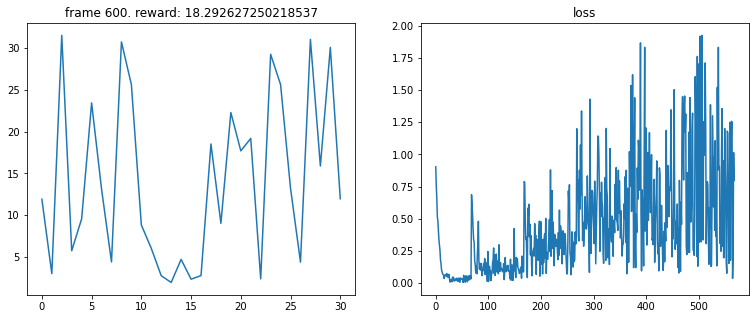

average reward = 18.292627250218537


KeyboardInterrupt: 

In [21]:
obj.train()

In [12]:
# standalone function evaluate model on the environment
def evaluate():
    checkpoint_path = "checkpoints/dueling-dqn-highway.pth"
    model = torch.load(checkpoint_path)
    env = gym.make("highway-v0")
    state = env.reset()
    done = False

    while done != True:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_value = model(state)
        action = q_value.argmax()
        action = action.item()
        state, reward, done, info = env.step(action)
        env.render()


In [13]:
evaluate()